Layer 1: ----------- 600
Layer 2: ----------- 512
Layer 3: ----------- 256
Layer 4: ----------- 128
Layer 5: ----------- 2
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


NMI Score for AE is: 32.43 and new cost is: 23.80 in 10 step. 
NMI Score for AE is: 36.54 and new cost is: 7.49 in 20 step. 
NMI Score for AE is: 42.70 and new cost is: 3.85 in 30 step. 
NMI Score for AE is: 53.92 and new cost is: 2.23 in 40 step. 
NMI Score for AE is: 66.66 and new cost is: 1.62 in 50 step. 
NMI Score for AE is: 75.75 and new cost is: 1.61 in 60 step. 
NMI Score for AE is: 75.51 and new cost is: 1.32 in 66 step. 


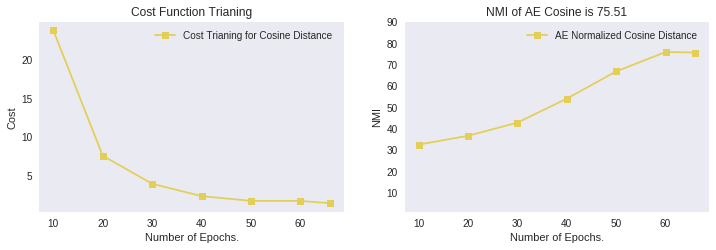

No handles with labels found to put in legend.


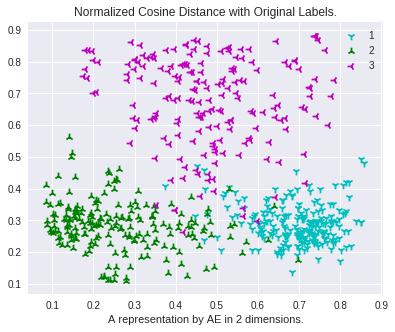

No handles with labels found to put in legend.


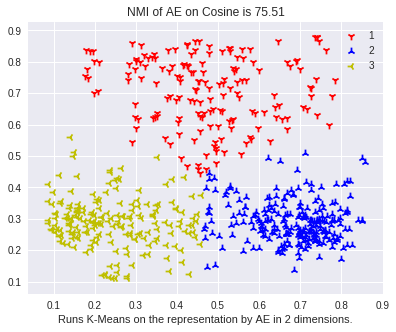

Autoencoder Clustering on Cosine: ------------ 75.51


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 18 12:57:57 2019

@author: rohith
"""

# Get important libraries for this class.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import sys
import logging
#-----------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from math import sqrt
#------------------------------------------------------------
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from optparse import OptionParser


def standardization(X):
    return normalize(X, axis=0)

def laplacian(A):
    S = np.sum(A, 0)
    D = np.diag(S)
    D = LA.matrix_power(D, -1)
    L = np.dot(D, A)
    return L

def normalization(V):
    return (V - min(V)) / (max(V) - min(V))

class Cosine_Similarity:
    def get_matrix(self, Data):
        X = standardization(Data)
        X = pdist(X, 'cosine')
        X = squareform(X)
        L = laplacian(X)
        Y = np.apply_along_axis(normalization, 1, L)
        return Y
    
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)
    
def read_NewsGroup_data(similarity):    
    categories_3NG = ['comp.graphics', 'rec.sport.baseball', 'talk.politics.guns']
    
    dataset = fetch_20newsgroups(subset='train', categories=categories_3NG,
                                 shuffle=True, random_state=42)
    
    labels = dataset.target[:600]
    true_k = np.unique(labels).shape[0]
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,min_df=2,
                                 stop_words='english',use_idf=True)
    X = vectorizer.fit_transform(dataset.data[:600])
    return Similarity_Dataset_Iterator(X.toarray(), labels, similarity)

def k_means_(X, n_cluster):
    kmeans_centroids,_ =  kmeans(X,n_cluster)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

def encoder(x, n_code, phase_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], mode_train)
        with tf.variable_scope("hidden-layer-2"):
            hidden_2 = layer(hidden_1, [n_hidden_1, n_hidden_2], [n_hidden_2], mode_train)
        with tf.variable_scope("hidden-layer-3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_3], [n_hidden_3], mode_train)        
        with tf.variable_scope("code"):
            code = layer(hidden_3, [n_hidden_3, n_code], [n_code], mode_train)
    return code

def decoder(code, n_code, mode_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(code, [n_code, n_hidden_3], [n_hidden_3], mode_train)
        with tf.variable_scope("hidden-layer-2"):
            hidden_2 = layer(hidden_1, [n_hidden_3, n_hidden_2], [n_hidden_2], mode_train)
        with tf.variable_scope("hidden-layer-3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_1], [n_hidden_1], mode_train)              
        with tf.variable_scope("reconstructed"):
            output = layer(hidden_3, [n_hidden_1, n_input], [n_input], mode_train)
    return output

def batch_norm(x, n_out, mode_train):
    beta_initialize = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_initialize = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_initialize)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_initialize)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode_train, mean_var, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

def layer(input, weight_shape, bias_shape, mode_train):
    value_initialize = (1.0 / weight_shape[0] ** 0.5)
    weight_initialize = tf.random_normal_initializer(stddev = value_initialize, seed = None)
    bias_initialize = tf.constant_initializer(value=0.0, dtype=tf.float32)
    w = tf.get_variable("w", weight_shape, initializer=weight_initialize)
    b = tf.get_variable("b", bias_shape, initializer=bias_initialize)
    return tf.nn.sigmoid(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

def loss(reconstructed, x):
    with tf.variable_scope("train"):
        train_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(reconstructed, x)), 1))
        return train_loss
    
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op



# Call Cosine_Similarity as similarity dataset.
trainSet_cosine = read_NewsGroup_data(Cosine_Similarity())
n_input = trainSet_cosine.data_size #--------- Number of input data.

# Define the number of hidden layer. 
if n_input >= 1024:
    Nn = int(2048)
elif n_input >= 512:
    Nn = int(1024)
elif n_input >= 256:
    Nn = int(512)

n_hidden_1 = int(Nn/2) #-------------------- The autoencoder hidden layer 1.
n_hidden_2 = int(n_hidden_1/2) #------------ The autoencoder hidden layer 2.
n_hidden_3 = int(n_hidden_2/2) #------------ The autoencoder hidden layer 3.
n_code = str(2) #--------------------------- The number of output dimension value.

print('Layer 1: -----------', n_input)
print('Layer 2: -----------', n_hidden_1)
print('Layer 3: -----------', n_hidden_2)
print('Layer 4: -----------', n_hidden_3)
print('Layer 5: -----------', int(n_code))


# Parameters
n_layers = 5 #----------------------------- Number of Neural Networks Layers.
beta1 = 0.9 #------------------------------ The decay rate 1.  
beta2 = 0.999 #---------------------------- The decay rate 2.
learning_rate = (beta1/n_input) #---------- The learning rate.
stop_learning = 1.35 #--------------------- The stop learning point.
n_batch = math.ceil(sqrt(sqrt(n_input))) #- Number of selection data in per step.
n_backpro = math.ceil(n_input/n_batch) #--- Number of Backpro in per epoch.
n_clusters = 3 #--------------------------- Number of clusters.
n_diplay = 10 #---------------------------- Number of getting code and runnig the K-Means.
data_cos, labels_cos = trainSet_cosine.whole_dataset() #------- Allocation of data and labels
results_cos=[] #--------------------------- A list to keep all NMI scores.
loss_cost_cos=[] #------------------------- A list to keep all training evaluations.
steps_cos=[] #----------------------------- A list to keep all steps.

#network design
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_architecture"):
        x = tf.placeholder("float", [None, n_input])   
        mode_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), mode_train)
        reconstructed = decoder(code, int(n_code), mode_train)
        cost = loss(reconstructed, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
# Training cycle
epoch = 0
while epoch == 0 or new_cost >= stop_learning:
    # Fit training with backpropagation using batch data.
    for i in range(n_backpro):
        miniData, _ = trainSet_cosine.next_batch(n_batch)
        _, new_cost = sess.run([train_optimizer,cost], feed_dict={x: miniData,
                                                                  mode_train: True})       
    #------------------------- End of the Optimization ------------------------------
    epoch += 1
    # Save the results after per 10 epochs.    
    if epoch % n_diplay == 0 or new_cost <= stop_learning:
        # Getting embedded codes and running K-Means on them.
        ae_codes_cos = sess.run(code, feed_dict={x: data_cos, mode_train: False})        
        idx_cos = k_means_(ae_codes_cos, n_clusters)
        ae_nmi_cos = normalized_mutual_info_score(labels_cos, idx_cos)
        ae_nmi_cos = ae_nmi_cos*100
        results_cos.append(ae_nmi_cos)    
        steps_cos.append(epoch)
        loss_cost_cos.append(new_cost)    
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi_cos, new_cost, epoch))
        
#plotting
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,3.5))
plt.subplot(1,2,1)
plt.plot(steps_cos, loss_cost_cos, label='Cost Trianing for Cosine Distance ', color='#E3CF57', marker='s')
plt.xlabel('Number of Epochs.')
plt.ylabel('Cost')
plt.grid()
plt.title('Cost Function Trianing')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.ylim(1, 90)
plt.plot(steps_cos, results_cos, label='AE Normalized Cosine Distance ', color='#E3CF57', marker='s')
plt.xlabel('Number of Epochs.')
plt.ylabel('NMI')
plt.grid()
plt.title(('NMI of AE Cosine is {:0.2f}').format(ae_nmi_cos))
plt.legend(loc='best')
plt.show()

origin_label_cos = np.array(trainSet_cosine.whole_dataset()[1]).astype(int)
colors = [('c', '1'),('g', '2'),('m','3')]
plt.figure(figsize=(14, 5))
for num in range(3):
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter([ae_codes_cos[:,0][i] for i in range(len(origin_label_cos)) if origin_label_cos[i] == num],
                [ae_codes_cos[:,1][i] for i in range(len(origin_label_cos)) if origin_label_cos[i] == num],
                60, label=str(num+1), color = colors[num][0], marker=colors[num][1])
    plt.title('Normalized Cosine Distance with Original Labels.')
    plt.xlabel('A representation by AE in 2 dimensions.')
    plt.legend()
plt.show()

colors = [('r', '1'),('b', '2'),('y','3')]
plt.figure(figsize=(14, 5))
for num in range(3):
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter([ae_codes_cos[:,0][i] for i in range(len(idx_cos)) if idx_cos[i] == num],
                [ae_codes_cos[:,1][i] for i in range(len(idx_cos)) if idx_cos[i] == num],
                60, label=str(num+1), color = colors[num][0], marker=colors[num][1])
    plt.title(('NMI of AE on Cosine is {:0.2f}').format(ae_nmi_cos))
    plt.xlabel('Runs K-Means on the representation by AE in 2 dimensions.')
    plt.legend()
plt.show()

print("Autoencoder Clustering on Cosine: ------------ {:0.2f}".format(ae_nmi_cos))






Layer 1: ----------- 600
Layer 2: ----------- 512
Layer 3: ----------- 256
Layer 4: ----------- 128
Layer 5: ----------- 2
NMI Score for AE is: 10.15 and new cost is: 23.93 in 10 step. 
NMI Score for AE is: 12.13 and new cost is: 7.65 in 20 step. 
NMI Score for AE is: 16.51 and new cost is: 3.52 in 30 step. 
NMI Score for AE is: 24.10 and new cost is: 2.30 in 40 step. 
NMI Score for AE is: 34.50 and new cost is: 1.55 in 50 step. 
NMI Score for AE is: 40.14 and new cost is: 1.31 in 59 step. 


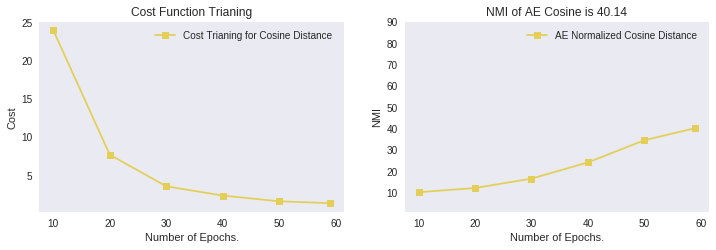

No handles with labels found to put in legend.


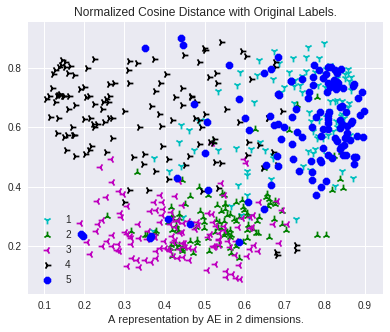

No handles with labels found to put in legend.


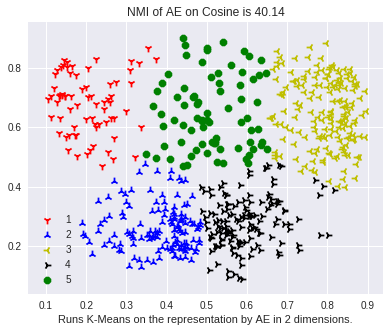

Autoencoder Clustering on Cosine: ------------ 40.14


In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 18 12:57:57 2019

@author: rohith
"""

# Get important libraries for this class.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
import sys
import logging
#-----------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from math import sqrt
#------------------------------------------------------------
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from optparse import OptionParser


def standardization(X):
    return normalize(X, axis=0)

def laplacian(A):
    S = np.sum(A, 0)
    D = np.diag(S)
    D = LA.matrix_power(D, -1)
    L = np.dot(D, A)
    return L

def normalization(V):
    return (V - min(V)) / (max(V) - min(V))

class Cosine_Similarity:
    def get_matrix(self, Data):
        X = standardization(Data)
        X = pdist(X, 'cosine')
        X = squareform(X)
        L = laplacian(X)
        Y = np.apply_along_axis(normalization, 1, L)
        return Y
    
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)
    
def read_NewsGroup_data(similarity):    
    categories_3NG = ['comp.graphics', 'rec.sport.baseball', 'talk.politics.guns', 'alt.atheism', 'talk.politics.mideast']
    
    dataset = fetch_20newsgroups(subset='train', categories=categories_3NG,
                                 shuffle=True, random_state=42)
    
    labels = dataset.target[:600]
    true_k = np.unique(labels).shape[0]
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,min_df=2,
                                 stop_words='english',use_idf=True)
    X = vectorizer.fit_transform(dataset.data[:600])
    return Similarity_Dataset_Iterator(X.toarray(), labels, similarity)

def k_means_(X, n_cluster):
    kmeans_centroids,_ =  kmeans(X,n_cluster)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

def encoder(x, n_code, phase_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], mode_train)
        with tf.variable_scope("hidden-layer-2"):
            hidden_2 = layer(hidden_1, [n_hidden_1, n_hidden_2], [n_hidden_2], mode_train)
        with tf.variable_scope("hidden-layer-3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_3], [n_hidden_3], mode_train)        
        with tf.variable_scope("code"):
            code = layer(hidden_3, [n_hidden_3, n_code], [n_code], mode_train)
    return code

def decoder(code, n_code, mode_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden-layer-1"):
            hidden_1 = layer(code, [n_code, n_hidden_3], [n_hidden_3], mode_train)
        with tf.variable_scope("hidden-layer-2"):
            hidden_2 = layer(hidden_1, [n_hidden_3, n_hidden_2], [n_hidden_2], mode_train)
        with tf.variable_scope("hidden-layer-3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_1], [n_hidden_1], mode_train)              
        with tf.variable_scope("reconstructed"):
            output = layer(hidden_3, [n_hidden_1, n_input], [n_input], mode_train)
    return output

def batch_norm(x, n_out, mode_train):
    beta_initialize = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_initialize = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_initialize)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_initialize)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode_train, mean_var, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

def layer(input, weight_shape, bias_shape, mode_train):
    value_initialize = (1.0 / weight_shape[0] ** 0.5)
    weight_initialize = tf.random_normal_initializer(stddev = value_initialize, seed = None)
    bias_initialize = tf.constant_initializer(value=0.0, dtype=tf.float32)
    w = tf.get_variable("w", weight_shape, initializer=weight_initialize)
    b = tf.get_variable("b", bias_shape, initializer=bias_initialize)
    return tf.nn.sigmoid(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

def loss(reconstructed, x):
    with tf.variable_scope("train"):
        train_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(reconstructed, x)), 1))
        return train_loss
    
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op



# Call Cosine_Similarity as similarity dataset.
trainSet_cosine = read_NewsGroup_data(Cosine_Similarity())
n_input = trainSet_cosine.data_size #--------- Number of input data.

# Define the number of hidden layer. 
if n_input >= 1024:
    Nn = int(2048)
elif n_input >= 512:
    Nn = int(1024)
elif n_input >= 256:
    Nn = int(512)

n_hidden_1 = int(Nn/2) #-------------------- The autoencoder hidden layer 1.
n_hidden_2 = int(n_hidden_1/2) #------------ The autoencoder hidden layer 2.
n_hidden_3 = int(n_hidden_2/2) #------------ The autoencoder hidden layer 3.
n_code = str(2) #--------------------------- The number of output dimension value.

print('Layer 1: -----------', n_input)
print('Layer 2: -----------', n_hidden_1)
print('Layer 3: -----------', n_hidden_2)
print('Layer 4: -----------', n_hidden_3)
print('Layer 5: -----------', int(n_code))


# Parameters
n_layers = 5 #----------------------------- Number of Neural Networks Layers.
beta1 = 0.9 #------------------------------ The decay rate 1.  
beta2 = 0.999 #---------------------------- The decay rate 2.
learning_rate = (beta1/n_input) #---------- The learning rate.
stop_learning = 1.35 #--------------------- The stop learning point.
n_batch = math.ceil(sqrt(sqrt(n_input))) #- Number of selection data in per step.
n_backpro = math.ceil(n_input/n_batch) #--- Number of Backpro in per epoch.
n_clusters = 5 #--------------------------- Number of clusters.
n_diplay = 10 #---------------------------- Number of getting code and runnig the K-Means.
data_cos, labels_cos = trainSet_cosine.whole_dataset() #------- Allocation of data and labels
results_cos=[] #--------------------------- A list to keep all NMI scores.
loss_cost_cos=[] #------------------------- A list to keep all training evaluations.
steps_cos=[] #----------------------------- A list to keep all steps.

#network design
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_architecture"):
        x = tf.placeholder("float", [None, n_input])   
        mode_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), mode_train)
        reconstructed = decoder(code, int(n_code), mode_train)
        cost = loss(reconstructed, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        
# Training cycle
epoch = 0
while epoch == 0 or new_cost >= stop_learning:
    # Fit training with backpropagation using batch data.
    for i in range(n_backpro):
        miniData, _ = trainSet_cosine.next_batch(n_batch)
        _, new_cost = sess.run([train_optimizer,cost], feed_dict={x: miniData,
                                                                  mode_train: True})       
    #------------------------- End of the Optimization ------------------------------
    epoch += 1
    # Save the results after per 10 epochs.    
    if epoch % n_diplay == 0 or new_cost <= stop_learning:
        # Getting embedded codes and running K-Means on them.
        ae_codes_cos = sess.run(code, feed_dict={x: data_cos, mode_train: False})        
        idx_cos = k_means_(ae_codes_cos, n_clusters)
        ae_nmi_cos = normalized_mutual_info_score(labels_cos, idx_cos)
        ae_nmi_cos = ae_nmi_cos*100
        results_cos.append(ae_nmi_cos)    
        steps_cos.append(epoch)
        loss_cost_cos.append(new_cost)    
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi_cos, new_cost, epoch))
        
#plotting
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,3.5))
plt.subplot(1,2,1)
plt.plot(steps_cos, loss_cost_cos, label='Cost Trianing for Cosine Distance ', color='#E3CF57', marker='s')
plt.xlabel('Number of Epochs.')
plt.ylabel('Cost')
plt.grid()
plt.title('Cost Function Trianing')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.ylim(1, 90)
plt.plot(steps_cos, results_cos, label='AE Normalized Cosine Distance ', color='#E3CF57', marker='s')
plt.xlabel('Number of Epochs.')
plt.ylabel('NMI')
plt.grid()
plt.title(('NMI of AE Cosine is {:0.2f}').format(ae_nmi_cos))
plt.legend(loc='best')
plt.show()

origin_label_cos = np.array(trainSet_cosine.whole_dataset()[1]).astype(int)
colors = [('c', '1'),('g', '2'),('m','3'),('k','4'),('b','8')]
plt.figure(figsize=(14, 5))
for num in range(5):
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter([ae_codes_cos[:,0][i] for i in range(len(origin_label_cos)) if origin_label_cos[i] == num],
                [ae_codes_cos[:,1][i] for i in range(len(origin_label_cos)) if origin_label_cos[i] == num],
                60, label=str(num+1), color = colors[num][0], marker=colors[num][1])
    plt.title('Normalized Cosine Distance with Original Labels.')
    plt.xlabel('A representation by AE in 2 dimensions.')
    plt.legend()
plt.show()

colors = [('r', '1'),('b', '2'),('y','3'),('k','4'),('g','8')]
plt.figure(figsize=(14, 5))
for num in range(5):
    plt.legend()
    plt.subplot(1,2,2)
    plt.scatter([ae_codes_cos[:,0][i] for i in range(len(idx_cos)) if idx_cos[i] == num],
                [ae_codes_cos[:,1][i] for i in range(len(idx_cos)) if idx_cos[i] == num],
                60, label=str(num+1), color = colors[num][0], marker=colors[num][1])
    plt.title(('NMI of AE on Cosine is {:0.2f}').format(ae_nmi_cos))
    plt.xlabel('Runs K-Means on the representation by AE in 2 dimensions.')
    plt.legend()
plt.show()

print("Autoencoder Clustering on Cosine: ------------ {:0.2f}".format(ae_nmi_cos))




